In [137]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import os
import logging
import sys
from sklearn import preprocessing

import torch
import torch.nn as nn
import torch.nn.functional as F


import random
import numpy as np
import pickle
import time

In [138]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [139]:
SMALL_SIZE =  14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


In [140]:
RUN             = '1'

seeds           = {'1':5123, '2':879, '3':9981, '4': 20075, '5': 66, '6': 276, '7': 936664}

conditional     = False
cond_on         = 'type'

root_model_data = '/global/cscratch1/sd/vboehm/Datasets/sdss/by_model/'
root_models     = '/global/cscratch1/sd/vboehm/Models/SDSS_AE/'
root_encoded    = '/global/cscratch1/sd/vboehm/Datasets/encoded/sdss/'
root_decoded    = '/global/cscratch1/sd/vboehm/Datasets/decoded/sdss/'


wlmin, wlmax    = (3388,8318)
fixed_num_bins  = 1000
min_SN          = 50
min_z           = 0.1
max_z           = 0.36
label           = 'galaxies_quasars_bins%d_wl%d-%d'%(fixed_num_bins,wlmin,wlmax)
label_          = label+'_minz%s_maxz%s_minSN%d'%(str(int(min_z*100)).zfill(3),str(int(max_z*100)).zfill(3),min_SN)
label_2         = label_+'_10_fully_connected_mean_div'

plotpath        = '/global/homes/v/vboehm/codes/SDSS_PAE/figures'


if conditional:
    label_2='conditional_%s'%cond_on+label_2
    
upsampling      = 'SMOTE'
fac             = 10

In [173]:
train_,valid_,test_,le = pickle.load(open(os.path.join(root_model_data,'combined_%s.pkl'%label_),'rb'))
encoded_train, encoded_valid, encoded_test = np.load(os.path.join(root_encoded,'encoded_%s_RUN%s.npy'%(label_2,RUN)), allow_pickle=True)
train, valid, test, mean, std = np.load(os.path.join(root_decoded,'decoded_%s_RUN%s.npy'%(label_2,RUN)), allow_pickle=True)

In [142]:
enc_weights = np.load('encoder_weights.npy', allow_pickle=True)
dec_weights = np.load('decoder_weights.npy', allow_pickle=True)

In [143]:
for ii in range(len(enc_weights)):
    print(enc_weights[ii].shape)


(1000, 1000)
(1000,)
(1000, 590)
(590,)
(590, 10)
(10,)


In [144]:
latent_dim      = 10
lr_final        = 1.3e-05
lr_init         = 7e-4
out_features    = [1000,590]

In [145]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)  

In [146]:
class Encoder(nn.Module):

    def __init__(self, seed):
        super(Encoder, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(fixed_num_bins, out_features[0])
        self.fc2 = nn.Linear(out_features[0],out_features[1])
        self.fc3 = nn.Linear(out_features[1], latent_dim)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(*hidden_init(self.fc3))

    def forward(self, state):
        x = torch.nn.LeakyReLU(negative_slope=0.3)(self.fc1(state))
        x = torch.nn.LeakyReLU(negative_slope=0.3)(self.fc2(x))
        x = self.fc3(x)
        return x

encoder=Encoder(time.time()).to(device)

In [147]:
encoder.fc1.weight.data=torch.from_numpy(np.transpose(enc_weights[0])).to(device)
encoder.fc1.bias.data=torch.from_numpy(enc_weights[1]).to(device)
encoder.fc2.weight.data=torch.from_numpy(np.transpose(enc_weights[2])).to(device)
encoder.fc2.bias.data=torch.from_numpy(enc_weights[3]).to(device)
encoder.fc3.weight.data=torch.from_numpy(np.transpose(enc_weights[4])).to(device)
encoder.fc3.bias.data=torch.from_numpy(enc_weights[5]).to(device)

In [148]:
pred = encoder.forward(torch.from_numpy(train_['spec'][:,:,0]).float().to(device))

In [149]:
pred.device

device(type='cuda', index=0)

In [150]:
class Decoder(nn.Module):
    """Decoder"""

    def __init__(self, seed):

        super(Decoder, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(latent_dim, out_features[1])
        self.fc2 = nn.Linear(out_features[1],out_features[0])
        self.fc3 = nn.Linear(out_features[0],fixed_num_bins)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(*hidden_init(self.fc3))

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = torch.nn.LeakyReLU(negative_slope=0.3)(self.fc1(state))
        x = torch.nn.LeakyReLU(negative_slope=0.3)(self.fc2(x))
        x = self.fc3(x)
        return x

decoder=Decoder(time.time()).to(device)

In [151]:
decoder.fc1.weight.data = torch.from_numpy(np.transpose(dec_weights[0])).to(device)
decoder.fc1.bias.data   = torch.from_numpy(dec_weights[1]).to(device)
decoder.fc2.weight.data = torch.from_numpy(np.transpose(dec_weights[2])).to(device)
decoder.fc2.bias.data   = torch.from_numpy(dec_weights[3]).to(device)
decoder.fc3.weight.data = torch.from_numpy(np.transpose(dec_weights[4])).to(device)
decoder.fc3.bias.data   = torch.from_numpy(dec_weights[5]).to(device)

In [152]:
for param in decoder.parameters():
    param.requires_grad = False
    
for param in encoder.parameters():
    param.requires_grad = False

In [71]:
dec = decoder.forward(pred)

In [158]:
MAP_test = np.load(os.path.join(root_encoded,'encoded_MAP_test_%s_RUN%s.npy'%(label_2,RUN)))
MAP_test_res = np.load(os.path.join(root_encoded,'encoded_MAP_test_%s_RUN%s_res.npy'%(label_2,RUN)))

In [159]:
len_iter = len(test_['spec'])//500

In [160]:
len(MAP_test.flatten())/10/len_iter, len(test_['spec'])

(7692.0, 7692)

In [161]:
MAP_test = MAP_test.reshape(len_iter,-1,10)

In [162]:
MAP_test.shape

(15, 7692, 10)

In [163]:
real_zs = []
for ii in range(MAP_test.shape[0]):
    real_zs.append(MAP_test[ii,ii*500:(ii+1)*500])
res = MAP_test_res[(ii+1)*500::]

In [164]:
real_zs     = np.asarray(real_zs)

In [165]:
real_zs     = real_zs.reshape(-1,10)
real_zs     = np.vstack([real_zs,res])

In [166]:
real_zs.shape

(7692, 10)

In [167]:
decoded_MAP = decoder.forward(torch.Tensor(real_zs).to(device)).detach().cpu().numpy()

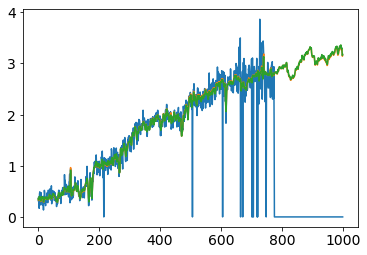

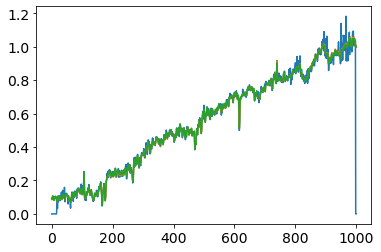

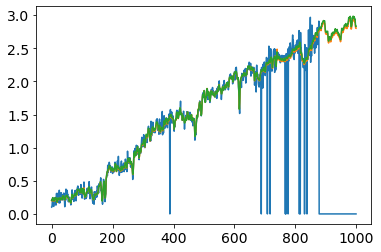

In [131]:
for ii in [-1,-2,-3]:
    plt.figure()
    plt.plot(test_['spec'][ii])
    plt.plot(test[ii])
    plt.plot(decoded_MAP[ii])
    plt.show()

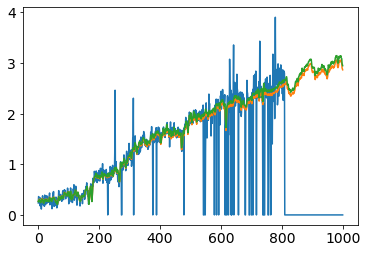

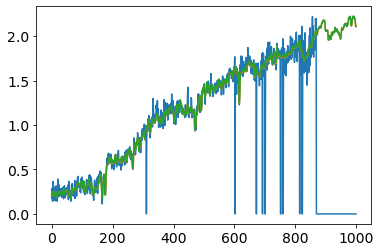

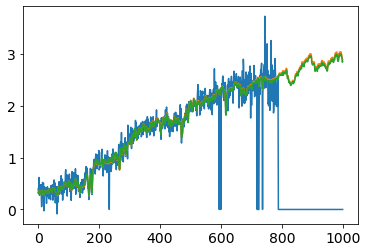

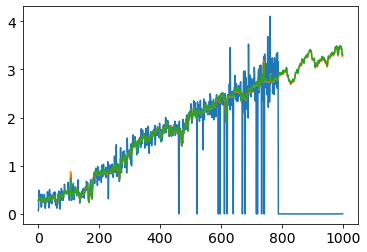

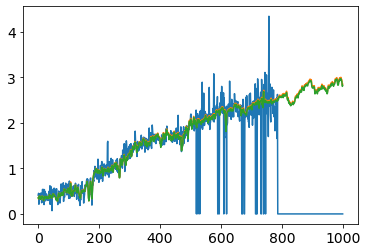

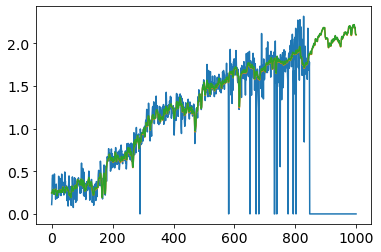

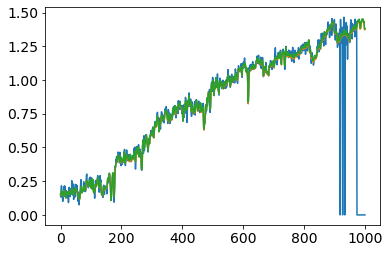

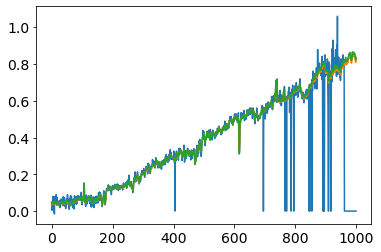

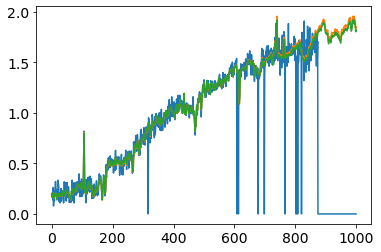

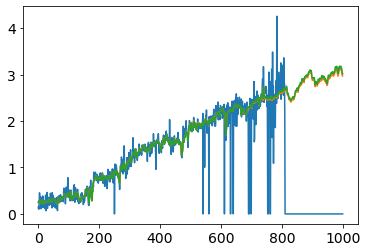

In [132]:
for ii in np.random.randint(size=10,low=0,high=len(decoded_MAP)):
    plt.figure()
    plt.plot(test_['spec'][ii])
    plt.plot(test[ii])
    plt.plot(decoded_MAP[ii])
    plt.show()

In [133]:
np.save(os.path.join(root_encoded,'encoded_MAP_test_%s_RUN%s_joined.npy'%(label_2,RUN)),real_zs)
np.save(os.path.join(root_decoded,'decoded_MAP_test_%s_RUN%s_joined.npy'%(label_2,RUN)),decoded_MAP)


In [170]:
encoded_2 = {}
decoded_2 = {}
for label in ['train','valid','test']:
    decoded = np.load(os.path.join(root_decoded,'decoded_MAP_%s_%s_RUN%s_joined.npy'%(label,label_2,RUN)),allow_pickle=True)
    encoded = encoder.forward(torch.Tensor(decoded).to(device))
    decoded = decoder.forward(encoded)
    encoded_2[label] = encoded.detach().cpu().numpy()
    decoded_2[label] = decoded.detach().cpu().numpy()

In [172]:
np.save(os.path.join(root_encoded,'encoded_2_MAP_test_%s_RUN%s_joined.npy'%(label_2,RUN)),encoded_2)
np.save(os.path.join(root_decoded,'decoded_2_MAP_test_%s_RUN%s_joined.npy'%(label_2,RUN)),decoded_2)

In [188]:
encoded_train_MAP = np.load(os.path.join(root_encoded,'encoded_MAP_train_%s_RUN%s_joined.npy'%(label_2,RUN)),allow_pickle=True)
decoded_train_MAP = np.load(os.path.join(root_decoded,'decoded_MAP_train_%s_RUN%s_joined.npy'%(label_2,RUN)),allow_pickle=True)


ind = np.argsort(np.sum((encoded_train_MAP-encoded_train)**2,axis=1))

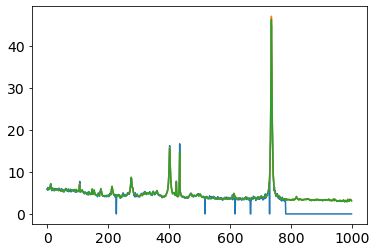

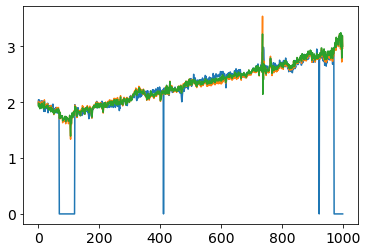

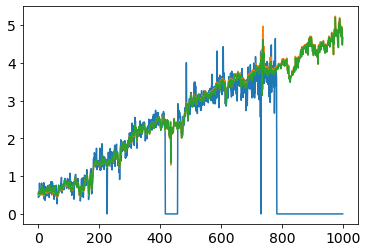

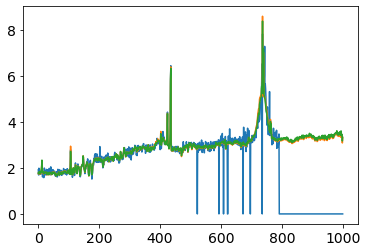

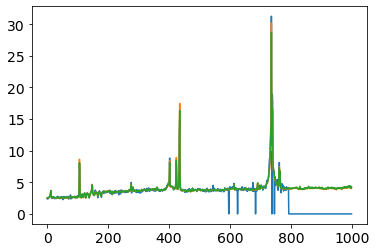

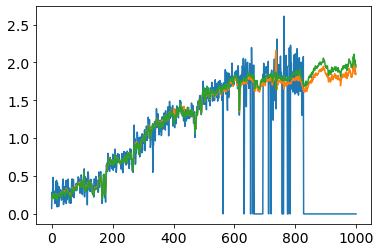

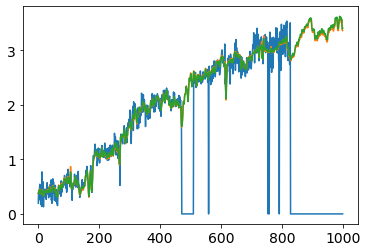

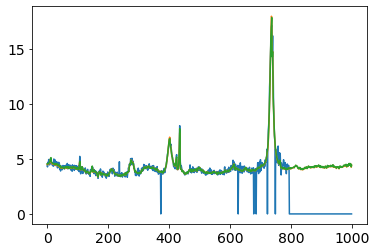

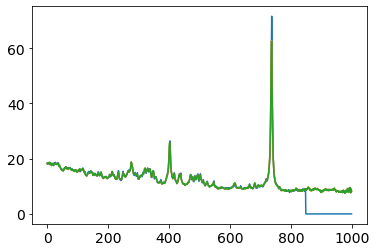

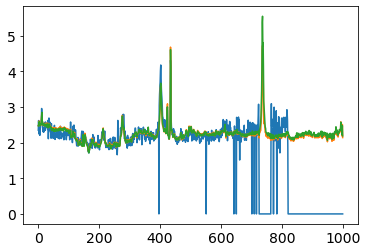

In [190]:
for ii in ind[-10::]:
    plt.figure()
    plt.plot(train_['spec'][ii])
    plt.plot(train[ii])
    plt.plot(decoded_train_MAP[ii])
    plt.show()